<a href="https://colab.research.google.com/github/czengnn/lana-del-rey-lyrics-generator/blob/main/LDR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [216]:
import pandas as pd 
import numpy as np 
import re 
import os
import time
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.layers.experimental import preprocessing

from tensorflow.keras.losses import sparse_categorical_crossentropy
from keras.models import Sequential, load_model
from keras.layers import LSTM, Activation, Flatten, Dropout, Dense, Embedding, TimeDistributed, Bidirectional
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils

In [186]:
# load songs
songs1 = pd.read_csv('/content/drive/MyDrive/data/lana_lyrics_83.csv').drop('Unnamed: 0', axis=1)
songs2 = pd.read_csv('/content/drive/MyDrive/data/lana_lyrics_15.csv').drop('Unnamed: 0', axis=1)
songs = pd.concat([songs1, songs2], axis=0)
songs.shape

(98, 2)

In [187]:
# test revoming text with brackets around them
test_text = songs2.lyrics[0][:50]
print(test_text)
print(re.sub(r'\[[^][]*\]', '', test_text))

[Verse 1]
Sun stare, don't care with my head in my

Sun stare, don't care with my head in my


In [188]:
# put lyrics into 1 string
text = ''
for song in songs['lyrics']:
    text = text + song.lower()
# remove the text with brackets around them, such as [Verse 1]
text = re.sub(r'\[[^][]*\]', '', text)

In [189]:
# length of text is the number of characters in it
print(f'Length of text: {len(text)} characters')

# The unique characters in the file
vocab = sorted(set(text))
print(f'{len(vocab)} unique characters')

Length of text: 161722 characters
61 unique characters


In [190]:
# taking a look at the first 300 characters
print(text[:300])


why? ("got that?")
who, me? ("louder!")
why? ("got that?")


feet don't fail me now
take me to the finish line
oh, my heart, it breaks every step that i take
but i'm hoping at the gates, they'll tell me that you're mine
walking through the city streets, is it by mistake or design?
i feel so alone o


In [191]:
ids_from_chars = preprocessing.StringLookup(vocabulary=list(vocab))
chars_from_ids = tf.keras.layers.experimental.preprocessing.StringLookup(vocabulary=ids_from_chars.get_vocabulary(), invert=True)

# join the characters back into strings
def text_from_ids(ids):
  return tf.strings.reduce_join(chars_from_ids(ids), axis=-1)

In [192]:
# Create training examples and targets
all_ids = ids_from_chars(tf.strings.unicode_split(text, 'UTF-8'))
all_ids

<tf.Tensor: shape=(161722,), dtype=int64, numpy=array([ 2, 45, 30, ..., 37, 44, 27])>

In [193]:
ids_dataset = tf.data.Dataset.from_tensor_slices(all_ids)

In [194]:
seq_length = 100
examples_per_epoch = len(text)//(seq_length+1)

In [197]:
sequences = ids_dataset.batch(seq_length+1, drop_remainder=True)

for seq in sequences.take(1):
  print(text_from_ids(seq).numpy())

b'\nwhy? ("got that?")\nwho, me? ("louder!")\nwhy? ("got that?")\n\n\nfeet don\'t fail me now\ntake me to the f'


In [198]:
def split_input_target(sequence):
    input_text = sequence[:-1]
    target_text = sequence[1:]
    return input_text, target_text

In [199]:
split_input_target(list("Tensorflow"))

(['T', 'e', 'n', 's', 'o', 'r', 'f', 'l', 'o'],
 ['e', 'n', 's', 'o', 'r', 'f', 'l', 'o', 'w'])

In [200]:
dataset = sequences.map(split_input_target)

for input_example, target_example in dataset.take(1):
    print("Input :", text_from_ids(input_example).numpy())
    print("Target:", text_from_ids(target_example).numpy())

Input : b'\nwhy? ("got that?")\nwho, me? ("louder!")\nwhy? ("got that?")\n\n\nfeet don\'t fail me now\ntake me to the '
Target: b'why? ("got that?")\nwho, me? ("louder!")\nwhy? ("got that?")\n\n\nfeet don\'t fail me now\ntake me to the f'


### Create training batches

In [201]:
# Batch size
BATCH_SIZE = 64

# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences,
# so it doesn't attempt to shuffle the entire sequence in memory. Instead,
# it maintains a buffer in which it shuffles elements).
BUFFER_SIZE = 10000

dataset = (
    dataset
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE))

dataset

<PrefetchDataset shapes: ((64, 100), (64, 100)), types: (tf.int64, tf.int64)>

### Building Model

In [202]:
# Length of the vocabulary in chars
vocab_size = len(vocab)

# The embedding dimension
embedding_dim = 256

# Number of RNN units
rnn_units = 512

In [223]:
class MyModel(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, rnn_units):
        super().__init__(self)
        self.embedding = Embedding(vocab_size, #61
                                   embedding_dim, #256
                                   batch_input_shape=[BATCH_SIZE, None]) #64
        self.LSTM_1 = Bidirectional(LSTM(rnn_units, #512
                           return_sequences=True,
                           stateful=True))
        self.Dropout_1 = Dropout(0.2)        
        self.LSTM_2 = LSTM(rnn_units, #512
                           return_sequences=True, 
                           stateful=True)
        self.Dropout_2 = Dropout(0.2) 
        self.dense_1 = Dense(vocab_size/2, activation='relu')
        self.dense_2 = Dense(vocab_size)

    def call(self, inputs, states=None, return_state=False, training=False):
        x = inputs
        x = self.embedding(x, training=training)
        x = self.LSTM_1(x, training=training)
        x = self.Dropout_1(x, training=training)
        x = self.LSTM_2(x, training=training)
        x = self.Dropout_2(x, training=training)
        x = self.dense_1(x, training=training)
        x = self.dense_2(x, training=training)
        return x
# ValueError: Input 0 is incompatible with layer forward_lstm_51: 
# expected shape=(64, None, 256), found shape=(1, None, 256)

In [204]:
model = MyModel(
    # Be sure the vocabulary size matches the `StringLookup` layers.
    vocab_size=len(ids_from_chars.get_vocabulary()),
    embedding_dim=embedding_dim,
    rnn_units=rnn_units)

In [205]:
for input_example_batch, target_example_batch in dataset.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(64, 100, 63) # (batch_size, sequence_length, vocab_size)


In [206]:
model.summary()

Model: "my_model_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_32 (Embedding)     multiple                  16128     
_________________________________________________________________
bidirectional_2 (Bidirection multiple                  3149824   
_________________________________________________________________
dropout_34 (Dropout)         multiple                  0         
_________________________________________________________________
lstm_52 (LSTM)               multiple                  3147776   
_________________________________________________________________
dropout_35 (Dropout)         multiple                  0         
_________________________________________________________________
dense_30 (Dense)             multiple                  15903     
_________________________________________________________________
dense_31 (Dense)             multiple                  

### Training the model

In [207]:
loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer='adam', loss=loss)

In [213]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2)
EPOCHS = 10

history = model.fit(dataset, 
                    epochs=EPOCHS, 
                    callbacks=[early_stopping])
model.save("/content/drive/MyDrive/data/models/LDR_tf_model")

Epoch 1/10
25/25 [==============================] - 224s 9s/step - loss: 0.1011
Epoch 2/10
25/25 [==============================] - 223s 9s/step - loss: 0.0963
Epoch 3/10
25/25 [==============================] - 222s 9s/step - loss: 0.0932
Epoch 4/10
25/25 [==============================] - 223s 9s/step - loss: 0.0903
Epoch 5/10
25/25 [==============================] - 222s 9s/step - loss: 0.0862
Epoch 6/10
25/25 [==============================] - 219s 9s/step - loss: 0.0852
Epoch 7/10
25/25 [==============================] - 216s 9s/step - loss: 0.0813
Epoch 8/10
25/25 [==============================] - 217s 9s/step - loss: 0.0790
Epoch 9/10
25/25 [==============================] - 216s 9s/step - loss: 0.0764
Epoch 10/10
25/25 [==============================] - 217s 9s/step - loss: 0.0746


INFO:tensorflow:Assets written to: /content/drive/MyDrive/data/models/LDR_tf_model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/data/models/LDR_tf_model/assets


In [214]:
# history = model.fit(X, Y, validation_split=0.33, epochs=150, batch_size=10, verbose=0)

# list all data in history
print(history.history.keys())

dict_keys(['loss'])


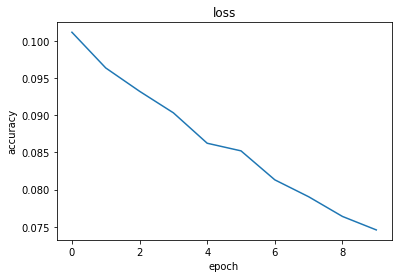

In [219]:

# summarize history for accuracy
plt.plot(history.history['loss'])
# plt.plot(history.history['val_accuracy'])
plt.title('loss')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

### Text Generation

In [224]:
class OneStep(tf.keras.Model):
  def __init__(self, model, chars_from_ids, ids_from_chars, temperature=1.0):
    super().__init__()
    self.temperature = temperature
    self.model = model
    self.chars_from_ids = chars_from_ids
    self.ids_from_chars = ids_from_chars

    # # Create a mask to prevent "" or "[UNK]" from being generated.
    # skip_ids = self.ids_from_chars(['', '[UNK]'])[:, None]
    # sparse_mask = tf.SparseTensor(
    #     # Put a -inf at each bad index.
    #     values=[-float('inf')]*len(skip_ids),
    #     indices=skip_ids,
    #     # Match the shape to the vocabulary
    #     dense_shape=[len(ids_from_chars.get_vocabulary())])
    # self.prediction_mask = tf.sparse.to_dense(sparse_mask)

  @tf.function
  def generate_one_step(self, inputs, states=None):
    # Convert strings to token IDs.
    input_chars = tf.strings.unicode_split(inputs, 'UTF-8')
    input_ids = self.ids_from_chars(input_chars).to_tensor()

    # Run the model.
    # predicted_logits.shape is [batch, char, next_char_logits]
    predicted_logits, states = self.model(inputs=input_ids, states=states,
                                          return_state=True)
    # Only use the last prediction.
    predicted_logits = predicted_logits[:, -1, :]
    predicted_logits = predicted_logits/self.temperature
    # Apply the prediction mask: prevent "" or "[UNK]" from being generated.
    predicted_logits = predicted_logits + self.prediction_mask

    # Sample the output logits to generate token IDs.
    predicted_ids = tf.random.categorical(predicted_logits, num_samples=1)
    predicted_ids = tf.squeeze(predicted_ids, axis=-1)

    # Convert from token ids to characters
    predicted_chars = self.chars_from_ids(predicted_ids)

    # Return the characters and model state.
    return predicted_chars, states

In [225]:
one_step_model = OneStep(model, chars_from_ids, ids_from_chars)

In [226]:
start = time.time()
states = None
next_char = tf.constant(['james dean'])
result = [next_char]

for n in range(100):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
print(result[0].numpy().decode('utf-8'), '\n\n' + '_'*80)


ValueError: ignored